[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import imageio
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from joblib import cpu_count, delayed, Parallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from displaytools import *
from improcessing import *
from rfextraction import *

# Read in image file

In [2]:
image_stack = cv2.imreadmulti('source_images/Control.tif', flags=cv2.IMREAD_GRAYSCALE)[1]

# Train models

## Extract mask image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 100.00, with offset=-4 and preserve_background=False.
Manually thresholding on values >=1.
Removing border of 1 pixels.
Closing with kernel size of 2.
Unmasking areas without edges using Canny[130, 180]:
Unmasking regions smaller than 50 pixels.


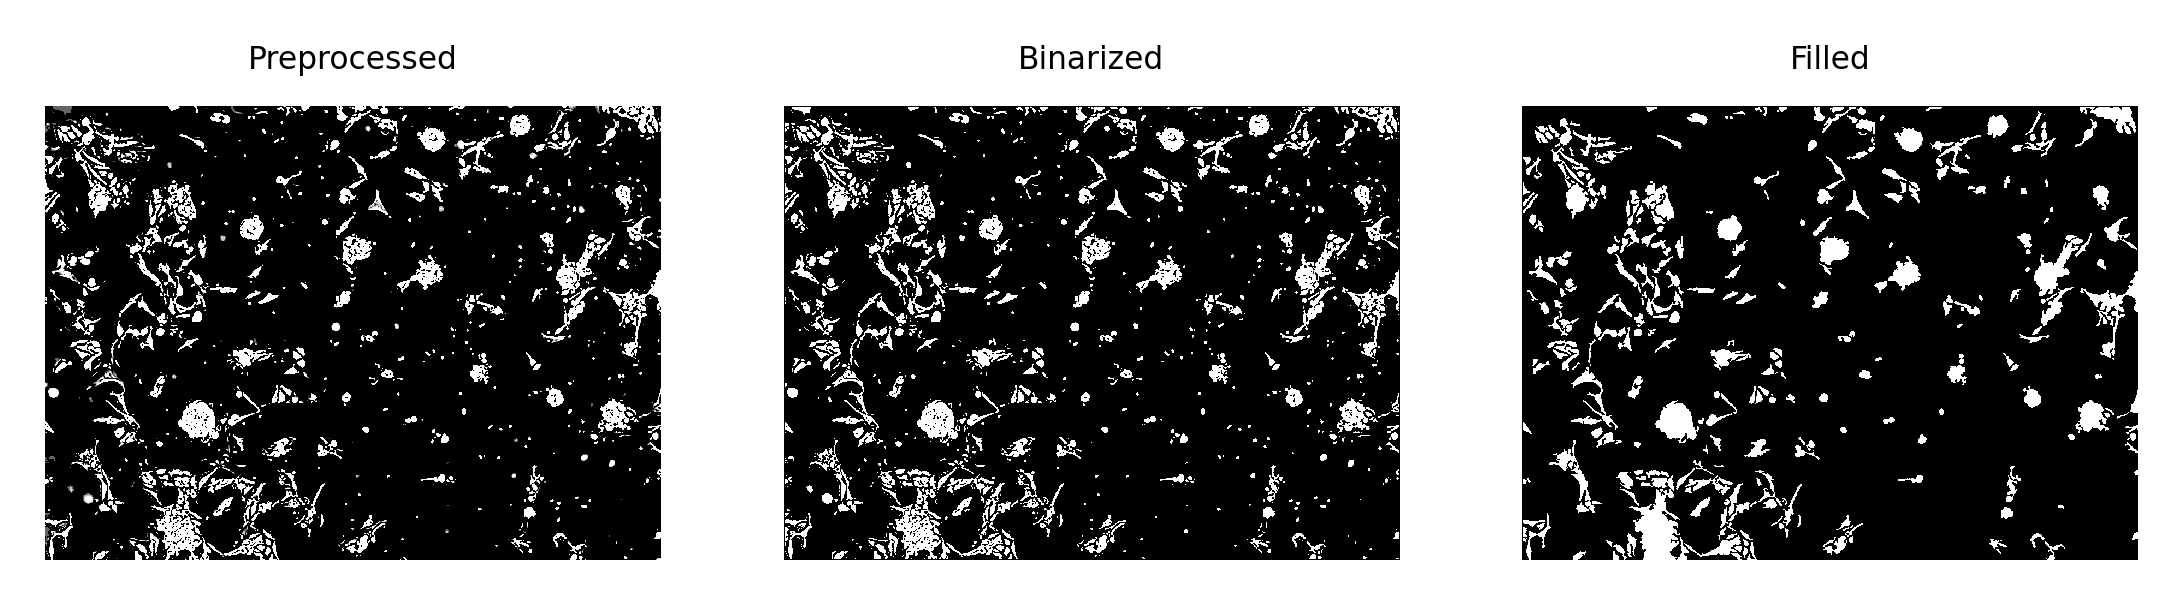

In [3]:
image_gray = scale_image(image_stack[0])
params = refine_offset(image_gray, 'params_gray_mask.yml')
mask_image = get_mask_image(image_gray, params, verbosity=2)

## Extract features, then standardize and reduce dimensions

In [4]:
df, mask_labels = extract_features(image_gray, mask_image)
# display(df)

In [5]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df)
dft = pd.DataFrame(pca.fit_transform(scaled), index=df.index)
# display(dft)

## Determine number of clusters

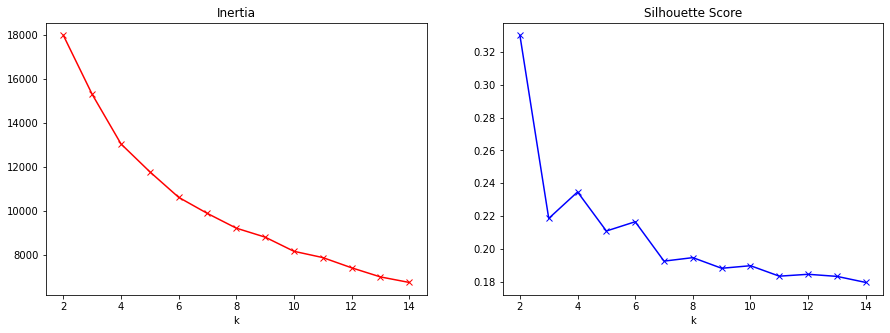

In [6]:
inertias = []
silhouette_scores = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(dft)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(dft, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(k_range, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(k_range, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette Score")
plt.show()

## User-defined values

`colormap` should contain `global_k` colors.

In [7]:
# Manually select k based on visual inspection above
global_k = 6

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange', 'green', 'purple'])

## Fit and classify using k-means

In [8]:
kmeans = KMeans(n_clusters=global_k, random_state=0)
labels = kmeans.fit_predict(dft)
print_label_counts(labels, colormap)

Class 0 (yellow): 62 (22.14%)
Class 1 (red): 53 (18.93%)
Class 2 (cyan): 87 (31.07%)
Class 3 (orange): 64 (22.86%)
Class 4 (green): 10 (3.57%)
Class 5 (purple): 4 (1.43%)


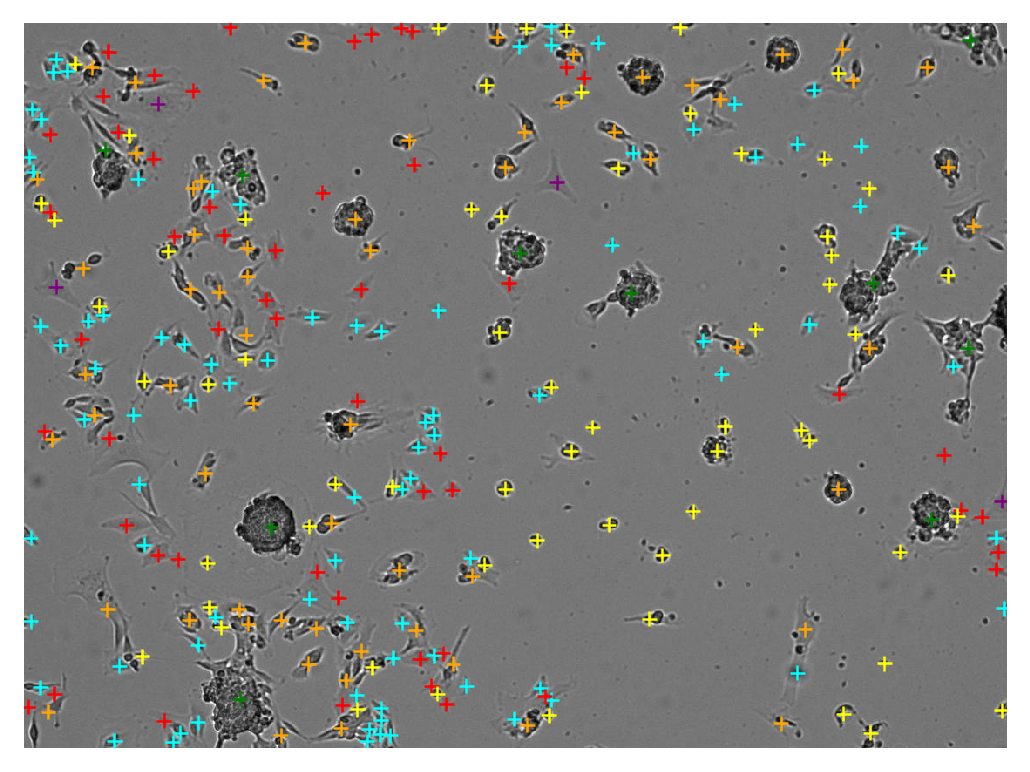

In [9]:
display_classifications(image_gray, dft.index, labels, colormap)

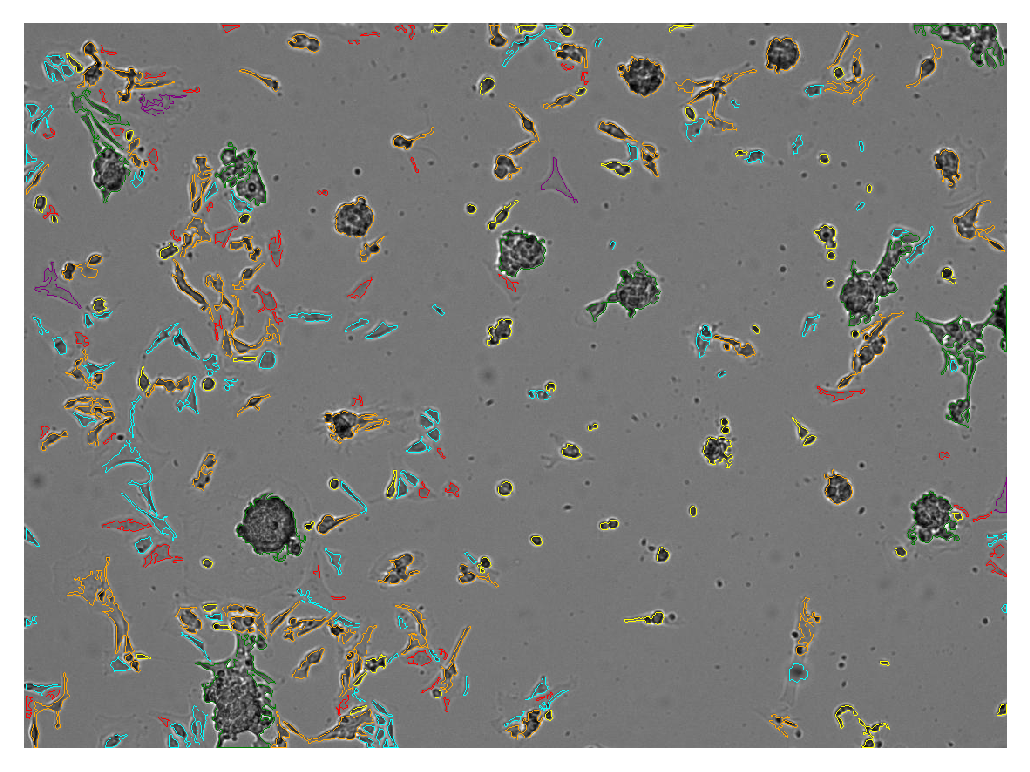

In [10]:
display_image(get_contoured_image(image_gray, mask_labels, labels, colormap))

Unfortunately `sklearn` doesn't let us set a colormap here so disregard the inconsistent coloring.

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


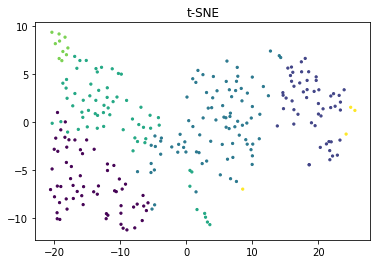

In [11]:
display_tsne(dft, labels)

# Estimate feature importance

In [12]:
num_features = 3

for k in range(labels.max()+1):
    y = np.uint8(labels==k)
    lr = LogisticRegression().fit(scaled, y)
    sorted_features = [(y, x) for x, y in sorted(zip(lr.coef_[0], df.columns))]
    print("Class %i:" % k)
    for feature, coeff in sorted_features[-num_features:]:
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))
    print("  ...")
    for feature, coeff in reversed(sorted_features[:num_features]):
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))

Class 0:
  shape2D_Sphericity: 0.600
  ngtdm_Strength: 0.629
  firstorder_90Percentile: 0.811
  ...
  firstorder_Median: -0.610
  firstorder_RootMeanSquared: -0.628
  gldm_LargeDependenceHighGrayLevelEmphasis: -0.705
Class 1:
  shape2D_Elongation: 0.428
  glcm_Imc1: 0.481
  glszm_LowGrayLevelZoneEmphasis: 0.628
  ...
  firstorder_Kurtosis: -0.563
  glrlm_LongRunLowGrayLevelEmphasis: -0.582
  glszm_LargeAreaLowGrayLevelEmphasis: -0.764
Class 2:
  glcm_Imc2: 0.617
  glcm_InverseVariance: 0.637
  firstorder_Kurtosis: 0.887
  ...
  glcm_ClusterTendency: -0.964
  glrlm_GrayLevelNonUniformityNormalized: -1.193
  glszm_LowGrayLevelZoneEmphasis: -1.494
Class 3:
  shape2D_MinorAxisLength: 0.715
  gldm_DependenceVariance: 1.058
  glszm_ZoneEntropy: 1.489
  ...
  glszm_GrayLevelNonUniformityNormalized: -0.884
  shape2D_Sphericity: -0.899
  shape2D_Perimeter: -1.167
Class 4:
  gldm_DependenceNonUniformity: 0.399
  glszm_GrayLevelNonUniformity: 0.399
  glrlm_RunLengthNonUniformity: 0.433
  ...
  gl

# Classify whole image stack

In [13]:
gray_images = image_stack

# gray_images = list(map(scale_image, image_stack[1::3]))
# fluor_images_1 = image_stack[0::3]
# fluor_images_2 = image_stack[2::3]
# max_1 = np.array(fluor_images_1).max()
# max_2 = np.array(fluor_images_2).max()

## Generate params for each image

In [14]:
params = Parallel(n_jobs=cpu_count())(delayed(refine_offset)(ig) for ig in tqdm(gray_images))

100%|████████████████████████████████████████████| 144/144 [53:49<00:00, 22.43s/it]


## Create mask images

144it [04:24,  1.84s/it]


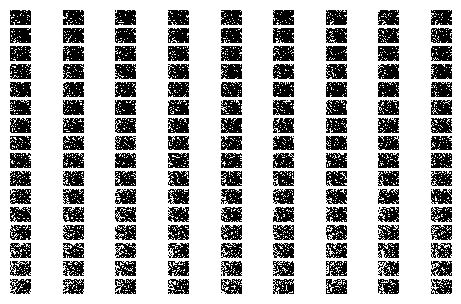

In [15]:
mask_images = \
    Parallel(n_jobs=cpu_count())(delayed(get_mask_image)(*_) for _ in tqdm(zip(gray_images, params)))

# Sanity check
display_image_array(mask_images, columns=9, dpi=100)

## Extract raw features in parallel

`get_mask_image` and `extract_features` are the most computationally expensive operations, and conveniently are also very easy to parallelize.

This cuts down runtime by >50%. Note that `tqdm` tracks process initiation, not completion, but this is a cheap and easy way to track progress.

In [16]:
result = \
    Parallel(n_jobs=cpu_count())(delayed(extract_features)(*_) for _ in tqdm(zip(gray_images, mask_images)))

144it [21:24,  8.92s/it]


## Pickle result in case kernel is lost
This takes up ~2GB on disk with `suspension_colour.tiff`, so don't do this automatically.

In [17]:
# with open("result.pickle", "wb") as outfile:
#     pickle.dump(result, outfile)

# with open("result.pickle", "rb") as infile:
#     result = pickle.load(infile)

## Process features, cluster using k-means, extract analysis data

This expects that the models have been trained in the cells above - we'll re-transform the first image but that's okay.

In [18]:
def esf_parallel(k, labels, mask_labels):
    masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
    if len(masks) == 0:
        return 0, 0
    sizes = list(map(np.sum, masks))
    return np.sum(sizes), int(np.mean(sizes))

# def esf_parallel(k, labels, mask_labels, flr_image_1, flr_image_2, max_1, max_2):
#     masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
#     sizes = list(map(np.sum, masks))
#     combined_mask = np.bitwise_or.reduce(masks, axis=0)
#     # do some magic arithmetic here to handle 0 values
#     combined_mask = np.int16(combined_mask) * 2 - 1
#     c1 = Counter(((combined_mask * (np.int16(flr_image_1)+5))-5).flatten())
#     c2 = Counter(((combined_mask * (np.int16(flr_image_2)+5))-5).flatten())
#     intensities = [c1[a] for a in range(max_1)], [c2[a] for a in range(max_2)]
#     return np.sum(sizes), int(np.mean(sizes)), np.array(intensities, dtype=int)

Image 0:


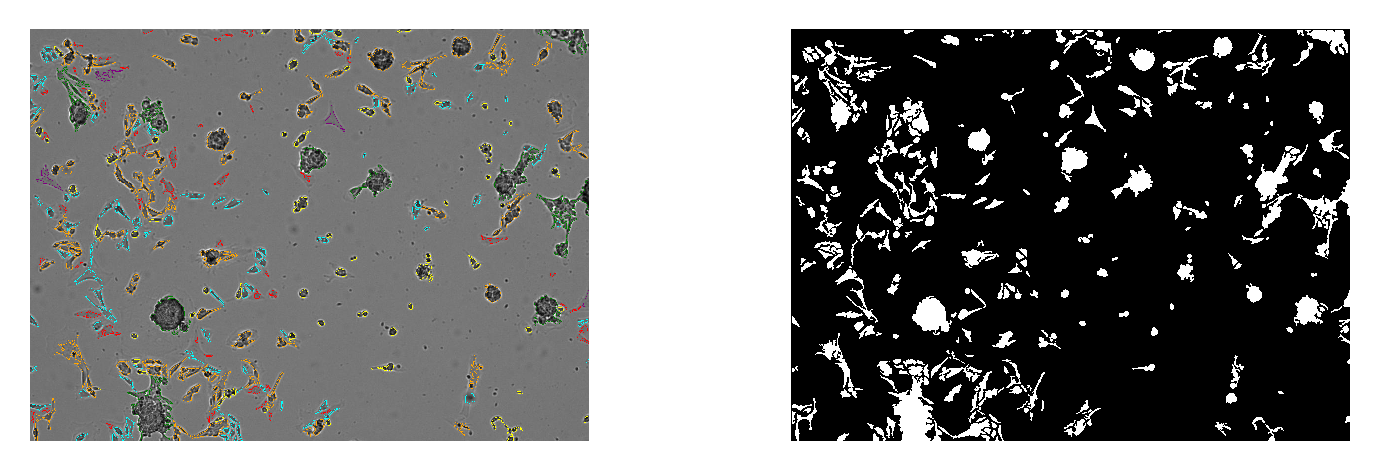

Image 15:


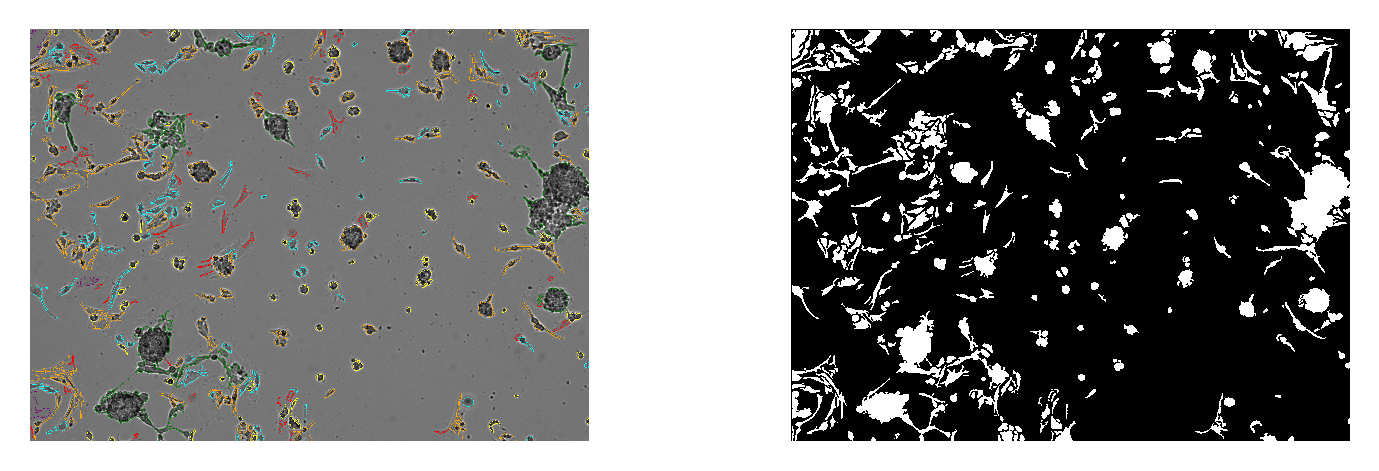

Image 30:


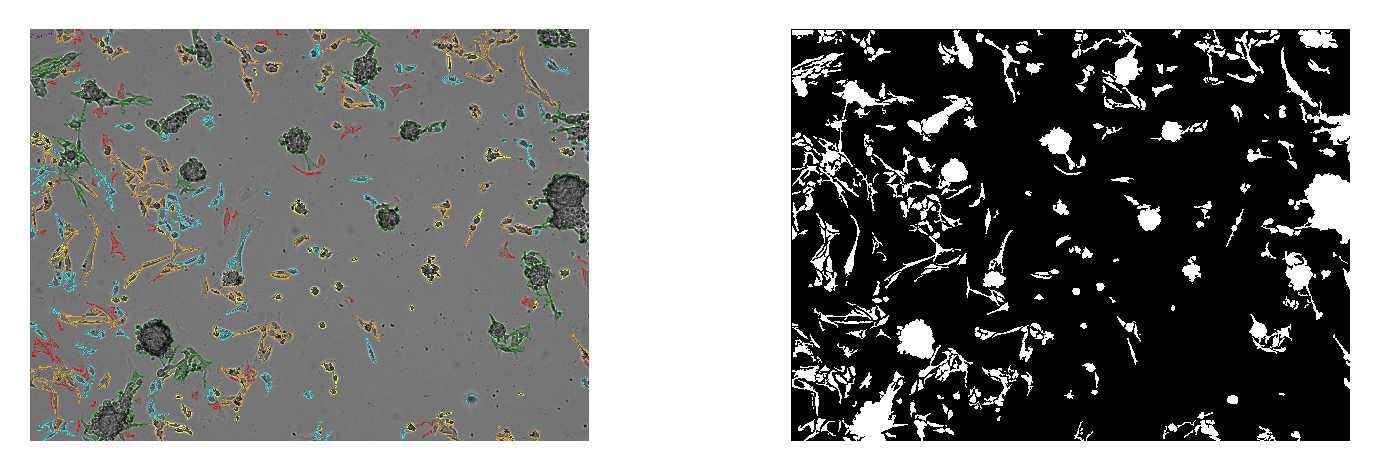

Image 45:


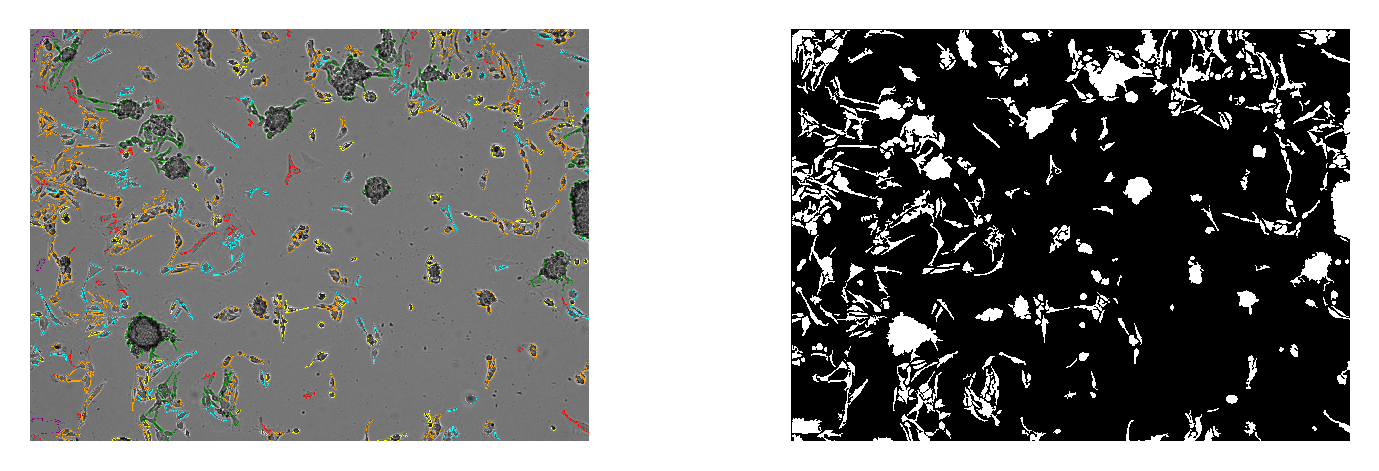

Image 60:


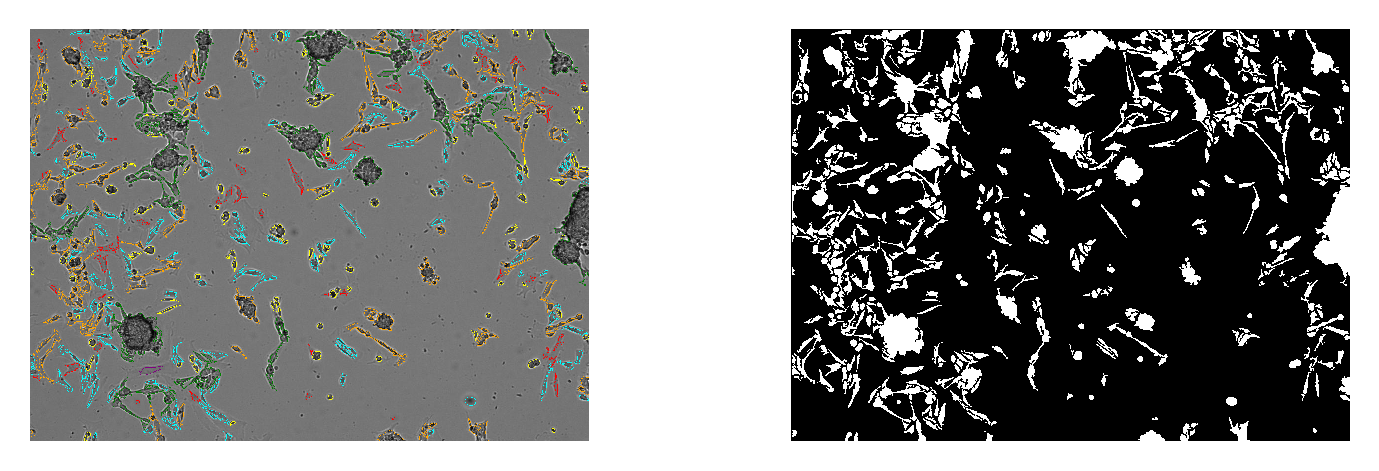

Image 75:


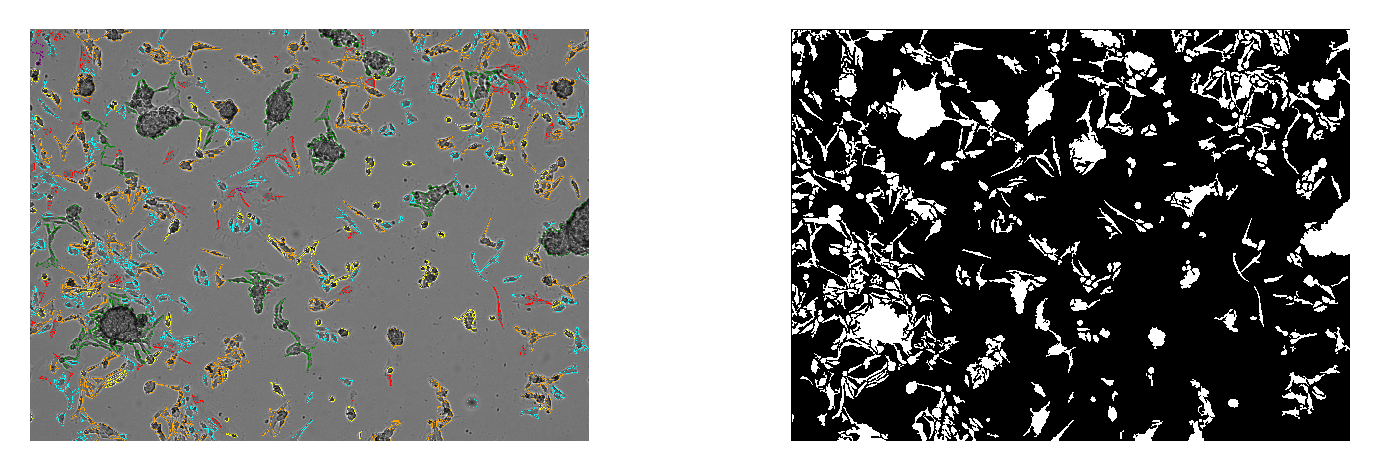

Image 90:


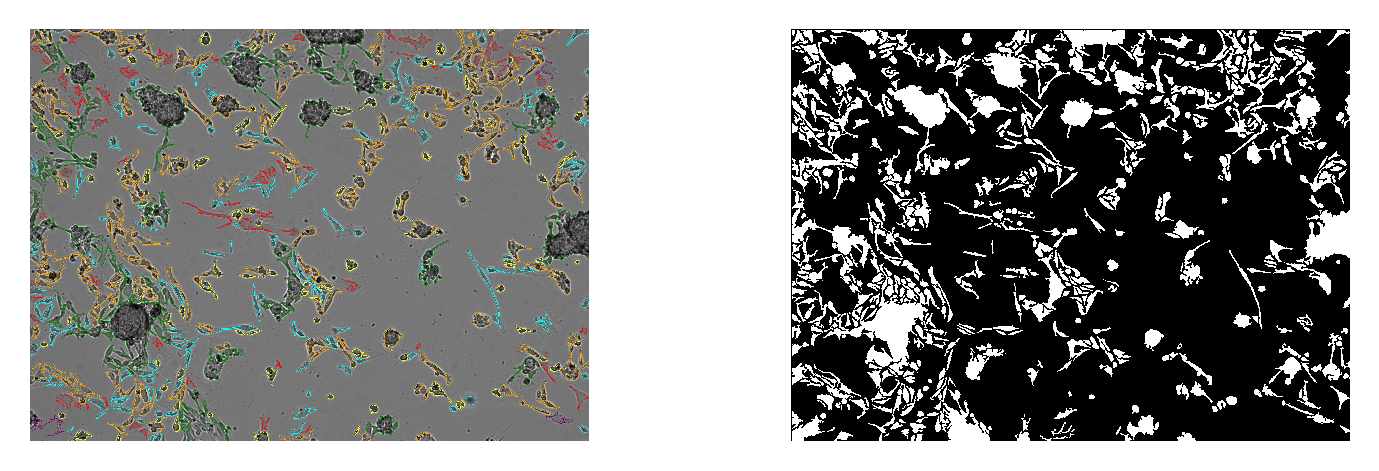

Image 105:


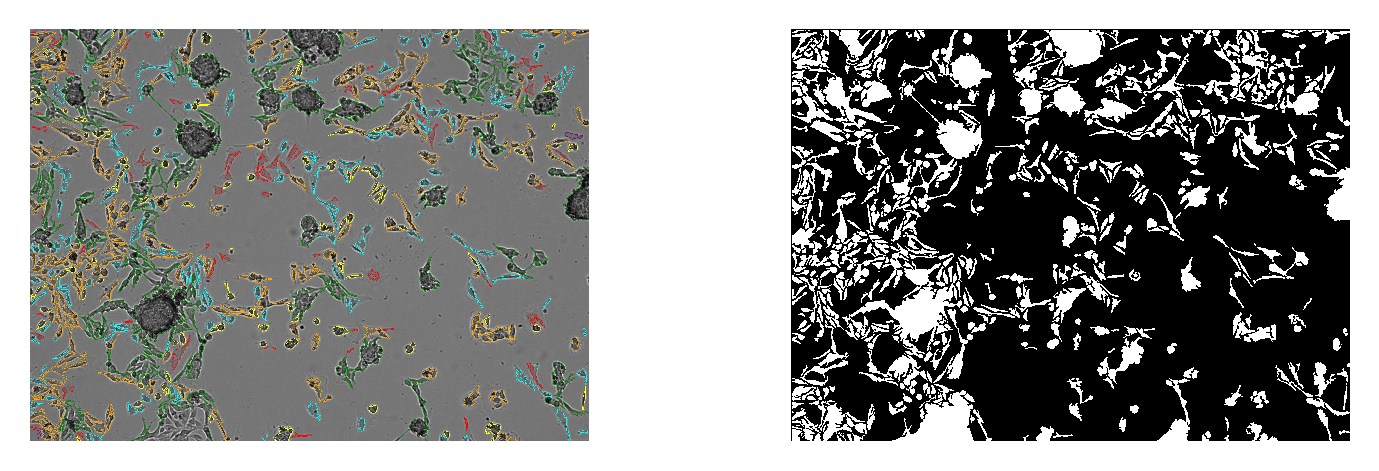

Image 120:


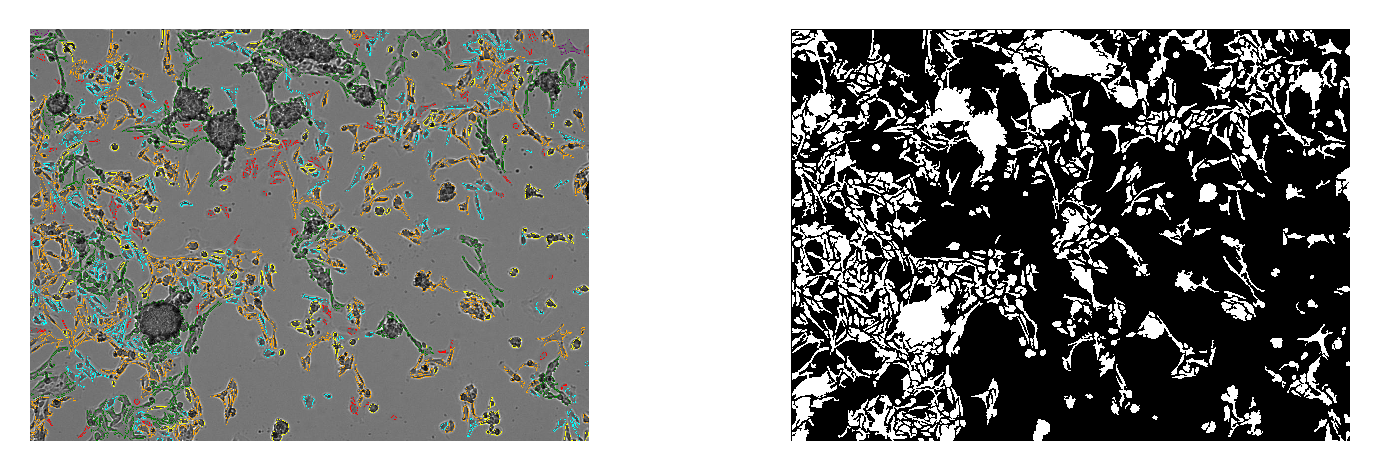

Image 135:


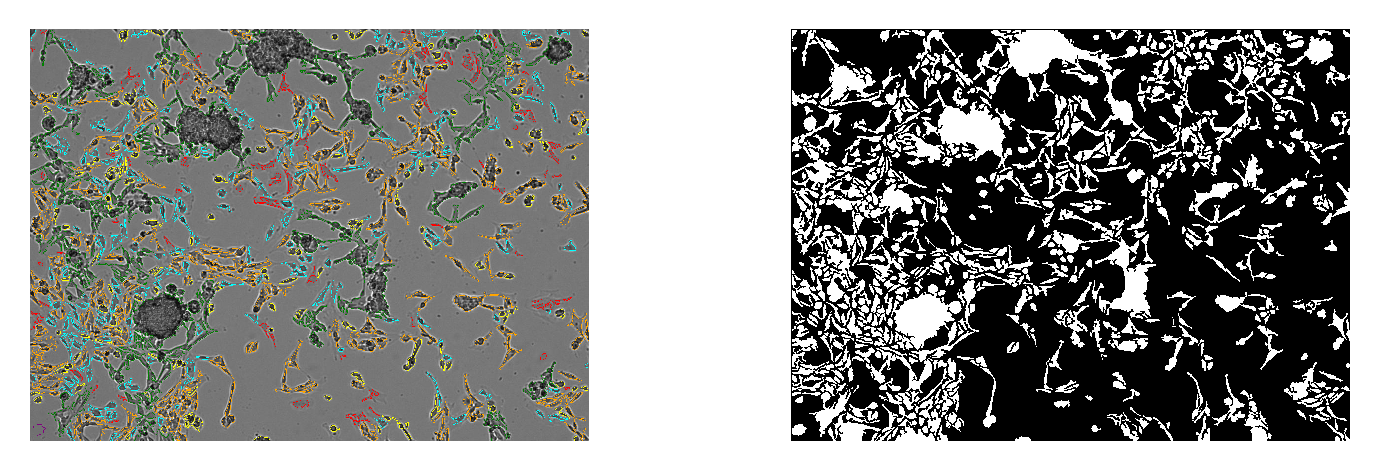

In [19]:
nc = kmeans.get_params()['n_clusters']

counts = np.zeros((len(result), nc))
total_sizes = np.zeros((len(result), nc))
mean_sizes = np.zeros((len(result), nc))
# intensities_1 = []
# intensities_2 = []

gif_buffer = []

# for every image in the image stack
for i in range(len(result)):
    df, mask_labels = result[i]

    # Preprocess features
    df = pd.DataFrame(pca.transform(scaler.transform(df)), index=df.index)
    
    # Cluster using k-means
    labels = kmeans.predict(df)
    
    # Count classes
    c = dict(Counter(labels))
    for k in range(nc):
        if k not in c:
            c[k] = 0
    counts[i] = [a[1] for a in sorted(c.items(), key=lambda a: a[0])]

    # Extract size & fluorescence data
    # NOTE: This step is parallelized since it's most computationally expensive by far, due
    # to the mask generation. This cuts down runtime by ~55%. We can consider parallelizing
    # by image frame but we'll have to look into copying sklearn models. We can also nest
    # generators for args rather than making identical copies of images but the number of
    # copies is small enough that this shouldn't be an important issue.
    args = zip(range(nc), [labels]*nc, [mask_labels]*nc)
#     args = zip(range(nc), [labels]*nc, [mask_labels]*nc, [fluor_images_1[i]]*nc,
#                [fluor_images_2[i]]*nc, [max_1]*nc, [max_2]*nc)
    fl_result = Parallel(n_jobs=cpu_count())(delayed(esf_parallel)(*a) for a in args)
    fl_result = np.array(fl_result, dtype=object)
    total_sizes[i] = fl_result[:,0]
    mean_sizes[i] = fl_result[:,1]
#     intensities = np.array([_ for _ in fl_result[:,2]], dtype=int)
#     intensities_1 += [intensities[:,0,:],]
#     intensities_2 += [intensities[:,1,:],]

    # Save for GIF creation
    contoured_image = get_contoured_image(gray_images[i], mask_labels, labels, colormap)
    gif_buffer.append(contoured_image)
    
    # Display sanity check images
    if i % 15 == 0:
        print("Image %i:" % i)
        display_image_array([contoured_image, np.uint8(mask_labels!=0)], columns=2, dpi=300)

counts = counts.T
total_sizes = total_sizes.T
mean_sizes = mean_sizes.T
# intensities_1 = np.swapaxes(np.array(intensities_1), 0, 1)
# intensities_2 = np.swapaxes(np.array(intensities_2), 0, 1)

## Save contoured images

In [20]:
imageio.mimsave('saved_images/contours/contours.gif', gif_buffer, duration=0.4)

for i in tqdm(range(len(gif_buffer))):
    imageio.imwrite(('saved_images/contours/%i.png' % i), gif_buffer[i])

100%|████████████████████████████████████████████| 144/144 [03:23<00:00,  1.41s/it]


## Plot class distributions

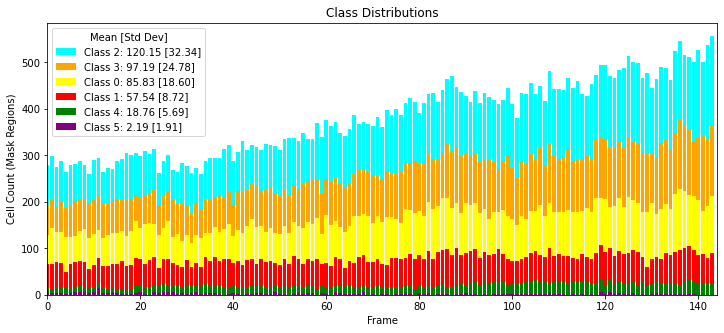

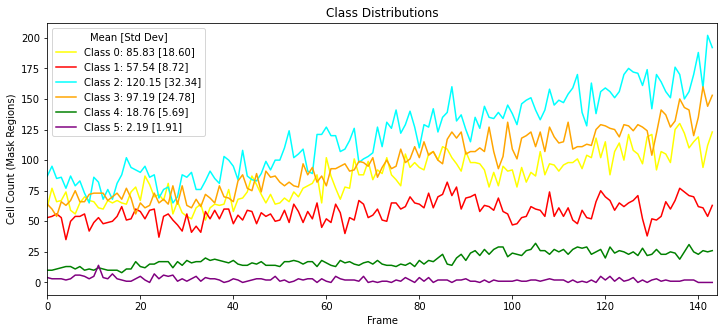

In [21]:
sorted_data = sorted(zip(counts, list(range(len(counts))),
                         np.mean(counts, axis=1), np.std(counts, axis=1)),
                     key=lambda a: a[0][-1])
bottom = np.zeros(counts.shape[1])
handles = []
plt.figure(figsize=(12,5))
plt.title("Class Distributions")
plt.ylabel("Cell Count (Mask Regions)")
plt.xlabel("Frame")
plt.xlim([0,len(sorted_data[0][0])])
for c, k, _, _ in sorted_data:
    handles += [plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[k]),]
    bottom += c
plt.legend(reversed(handles),
           [("Class %i: %.2f [%.2f]" % a[1:]) for a in reversed(sorted_data)],
           title="Mean [Std Dev]")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Class Distributions")
plt.ylabel("Cell Count (Mask Regions)")
plt.xlabel("Frame")
plt.xlim([0,len(sorted_data[0][0])])
for k in range(len(counts)):
    plt.plot(counts[k], color=colormap.colors[k],
             label=("Class %i: %.2f [%.2f]" % (k, np.mean(counts[k]), np.std(counts[k]))))
plt.legend(title="Mean [Std Dev]")
plt.show()

## Plot class sizes

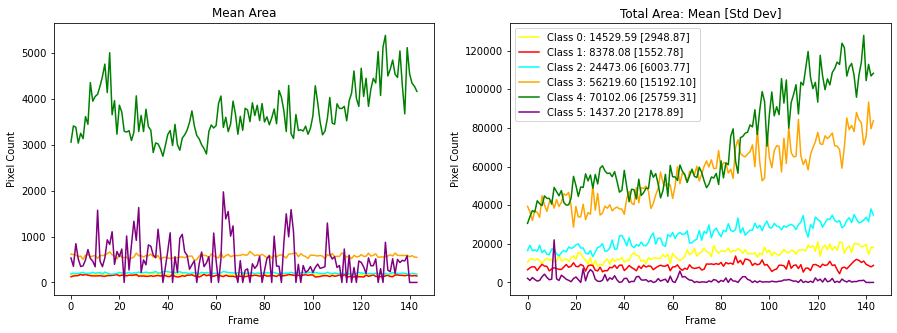

In [22]:
meanstd = list(zip(np.mean(total_sizes, axis=1), np.std(total_sizes, axis=1)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title("Mean Area")
ax1.set_ylabel("Pixel Count")
ax1.set_xlabel("Frame")
for k in range(len(mean_sizes)):
    ax1.plot(mean_sizes[k], color=colormap.colors[k], label=("Class %i" % k))

ax2.set_title("Total Area: Mean [Std Dev]")
ax2.set_ylabel("Pixel Count")
ax2.set_xlabel("Frame")
for k in range(len(total_sizes)):
    ax2.plot(total_sizes[k], color=colormap.colors[k],
             label=("Class %i: %.2f [%.2f]" % (k, *meanstd[k])))
ax2.legend()

plt.show()

## Plot fluorescence heatmaps

We plot raw counts of pixels here. We can also plot % of pixels (within the class area) using the code below but that gives us a visually near-identical heatmap.
```
prop_1 = np.divide(intensities_1, np.expand_dims(total_sizes, 2))
prop_2 = np.divide(intensities_2, np.expand_dims(total_sizes, 2))
```

In [23]:
# fig, axs = plt.subplots(intensities_1.shape[0], 2, figsize=(17,20))
# axs[0,0].set_title("Fluorescence %i" % 1)
# axs[0,1].set_title("Fluorescence %i" % 2)

# for i in range(intensities_1.shape[0]):
#     # Adding 1 here is a hacky trick to avoid taking the log of 0
#     sns.heatmap(intensities_1[i].T+1, ax=axs[i,0], norm=matplotlib.colors.LogNorm())
#     sns.heatmap(intensities_2[i].T+1, ax=axs[i,1], norm=matplotlib.colors.LogNorm(),
#                 cbar_kws={'label': "Pixel Count"})
#     axs[i,0].set_ylabel(("Class %i\nPixel Intensity" % i), size='large')
#     axs[i,0].invert_yaxis()
#     axs[i,1].invert_yaxis()
#     if i == intensities_1.shape[0]-1:
#         axs[i,0].set_xlabel("Frame")
#         axs[i,1].set_xlabel("Frame")

## Plot fluorescence percentiles

In [24]:
# def get_perc_val_from_counts(counts, percentile):
#     pidx = int(sum(counts) * percentile / 100)
#     for i in range(len(counts)):
#         if pidx > counts[i]:
#             pidx -= counts[i]
#         else:
#             return i

# def plot_fluorescence(intensities_1, intensities_2, percentile=50):
#     perc_values_1 = np.zeros((intensities_1.shape[1], intensities_1.shape[0]))
#     for i in range(intensities_1.shape[1]):
#         perc_values_1[i] = list(map(get_perc_val_from_counts,
#                                     intensities_1[:,i,:], [percentile]*len(intensities_1)))
#     perc_values_1 = perc_values_1.T

#     perc_values_2 = np.zeros((intensities_2.shape[1], intensities_2.shape[0]))
#     for i in range(intensities_2.shape[1]):
#         perc_values_2[i] = list(map(get_perc_val_from_counts,
#                                     intensities_2[:,i,:], [percentile]*len(intensities_2)))
#     perc_values_2 = perc_values_2.T

#     plt.figure(figsize=(15, 5))
#     for i in range(len(perc_values_1)):
#         plt.subplot(1,2,1)
#         plt.plot(perc_values_1[i], color=colormap.colors[i])
#         plt.title("Fluorescence 1 - %ith Percentile" % percentile)
#         plt.ylabel("Pixel Intensityß")
#         plt.xlabel("Frame")
#         plt.ylim(0, 40)

#         plt.subplot(1,2,2)
#         plt.plot(perc_values_2[i], color=colormap.colors[i])
#         plt.title("Fluorescence 2 - %ith Percentile" % percentile)
#         plt.xlabel("Frame")
#         plt.ylim(0, 40)
#     plt.show()

# plot_fluorescence(intensities_1, intensities_2, 95)
# plot_fluorescence(intensities_1, intensities_2, 99)